In [1]:
import pandas as pd
import datetime as dt
import pandas_datareader
import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib inline

In [2]:
#load data
start = dt.datetime(1995,1,1)
end   = dt.date.today()
data = pandas_datareader.data.DataReader('TSLA','yahoo',start,end)
data.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,18766300,23.889999
2010-06-30,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2010-07-01,25.000000,25.92,20.270000,21.959999,8218800,21.959999
2010-07-02,23.000000,23.10,18.709999,19.200001,5139800,19.200001
2010-07-06,20.000000,20.00,15.830000,16.110001,6866900,16.110001


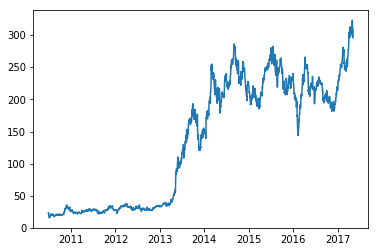

In [3]:
plt.plot(data['Adj Close'])

In [5]:
df = data['Adj Close']
df.to_csv('TSLA.csv', index=False)

In [17]:
#Step 1 Load Data
X_train, y_train, X_test, y_test = load_data('TSLA.csv', 50, True)

In [18]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : ', time.time() - start)

compilation time :  0.008350133895874023


In [19]:
#Step 3 Train the model
model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=5,
    validation_split=0.05)

Train on 1273 samples, validate on 68 samples
Epoch 1/5
1273/1273 [==============================] - 4s - loss: 0.0810 - val_loss: 0.0115
Epoch 2/5
1273/1273 [==============================] - 3s - loss: 0.0215 - val_loss: 0.0092
Epoch 3/5
1273/1273 [==============================] - 3s - loss: 0.0130 - val_loss: 0.0092
Epoch 4/5
1273/1273 [==============================] - 3s - loss: 0.0116 - val_loss: 0.0080
Epoch 5/5
1273/1273 [==============================] - 3s - loss: 0.0112 - val_loss: 0.0094


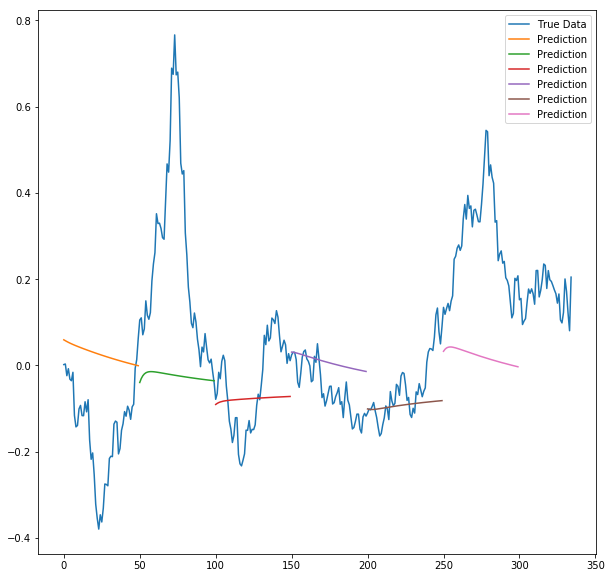

In [20]:
#Step 4 - Plot the predictions!
predictions = predict_sequences_multiple(model, X_test, 50, 50)
plot_results_multiple(predictions, y_test, 50)

In [16]:
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white', figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #print('yo')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'r').read()
    data = f.split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.8 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs